In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras.backend as K

gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)
session = tf.Session(config=config) 
K.set_session(session)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU Not Found!')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import pandas as pd

from PIL import Image

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.utils import vis_utils

import matplotlib.pyplot as plt

# configure matplotlib
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
train = pd.read_csv('data/train.csv')
train.head()

,Emotion,Pixels
0,3,221 240 251 254 255 255 255 255 255 255 255 25...
1,6,100 107 108 104 103 113 117 115 120 130 138 14...
2,4,35 50 56 57 63 76 74 79 85 86 105 133 145 152 ...
3,6,119 124 129 135 136 140 142 149 159 156 163 16...
4,2,160 173 186 194 188 185 175 162 153 143 135 12...


In [4]:
H, W = 48, 48
SIZE = (H, W)
N_PIX = H*W

In [5]:
X = train['Pixels'].str.split(' ').apply(lambda x: np.array([int(xx) for xx in x])).values
X = np.array([[xx for xx in x] for x in X])
X = X.reshape([X.shape[0], H, W])

In [6]:
y = train['Emotion']

n_emotions = y.nunique()
sorted(y.unique())

[0, 1, 2, 3, 4, 5, 6]

In [7]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None, img_size=(28,20)):
    img_rows, img_cols = img_size
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()

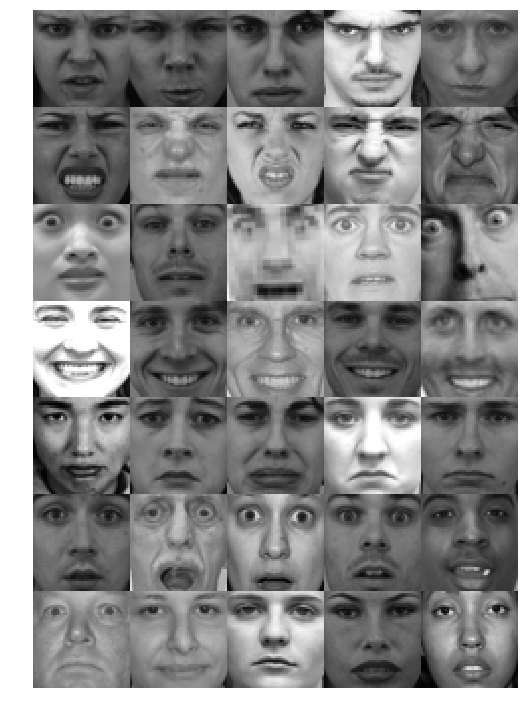

In [8]:
top_n_to_show = 5
to_show = np.array([X[y==i][:top_n_to_show] for i in range(n_emotions)])
to_show = to_show.reshape((to_show.shape[0]*to_show.shape[1],) + to_show.shape[2:])
show_examples(to_show, n=to_show.shape[0], n_cols=top_n_to_show, img_size=SIZE)

In [9]:
X = X.astype('float32') / 255.0
X = X.reshape([X.shape[0], 48*48])

In [10]:
intermediate_dim = 1024
latent_dim = 16
batch_size = 256
epochs = 500
noise_std = .01

In [11]:
img_inp = Input(shape=(N_PIX,))
h = Dense(intermediate_dim, activation="relu")(img_inp)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    bs = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(bs, latent_dim), mean=0., stddev=noise_std)
    epsilon *= K.exp(.5 * z_log_var)
    epsilon += z_mean
    return epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])    

In [13]:
decoder_h1 = Dense(intermediate_dim, activation="relu")
decoder_h2 = Dense(N_PIX, activation="sigmoid")
z_decoded = decoder_h1(z)
x_decoded = decoder_h2(z_decoded)

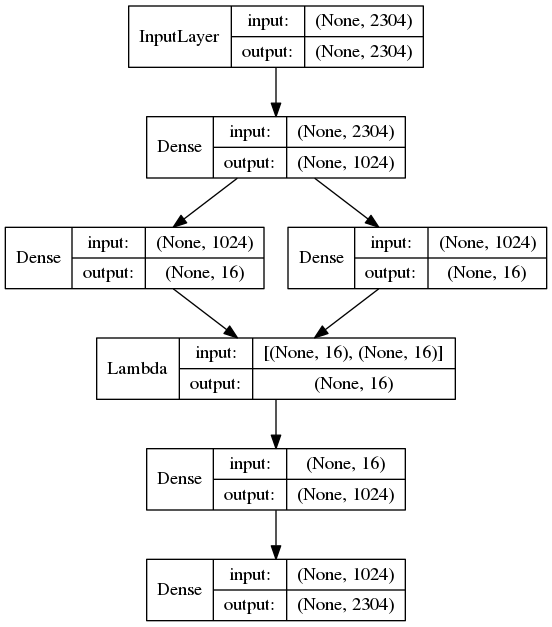

In [14]:
vae = Model(inputs=img_inp, outputs=x_decoded)
vis_utils.plot_model(vae, "vae.png", show_layer_names=False, show_shapes=True)
Image.open('vae.png')

In [15]:
def vae_objective(x, x_decoded):
    loss = binary_crossentropy(x, x_decoded)
    kl_regu = -.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return loss + kl_regu

In [16]:
vae.compile(optimizer="adam", loss=vae_objective)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [18]:
%%time
hist_cb = vae.fit(X_train, X_train, shuffle=True, 
                  epochs=epochs, batch_size=batch_size, 
                  verbose=0, validation_data=(X_test, X_test))

CPU times: user 1min 21s, sys: 11.3 s, total: 1min 32s
Wall time: 57.1 s


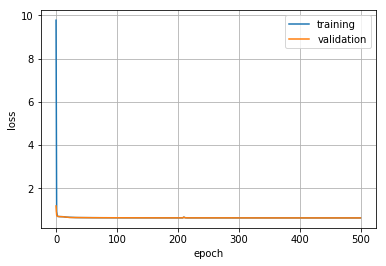

In [19]:
plt.plot(hist_cb.history["loss"], label="training")
plt.plot(hist_cb.history["val_loss"], label="validation")
plt.grid("on")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best");

In [20]:
encoder = Model(inputs=img_inp, outputs=z_mean)

In [21]:
decoder_input = Input(shape=(latent_dim,))
h_decoded = decoder_h1(decoder_input)
x_decoded = decoder_h2(h_decoded)
generator = Model(inputs=decoder_input, outputs=x_decoded)

In [22]:
from ipywidgets import FloatSlider, interact

d = {'c'+str(i): FloatSlider(min=-15, max=15, step=3, value=0) for i in range(latent_dim)}

@interact(**d)
def do_thumb(**args):
    z_sample = np.array([list(args.values())]) * noise_std
    x_decoded = generator.predict(z_sample)
    face = x_decoded[0].reshape(48, 48)
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(111)
    ax.imshow(face)
    plt.axis("off")

interactive(children=(FloatSlider(value=0.0, description='c0', max=15.0, min=-15.0, step=3.0), FloatSlider(val…